In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout, BatchNormalization, Add, GlobalAveragePooling2D, concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

2024-07-10 22:53:17.450450: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 22:53:17.459771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 22:53:17.473480: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 22:53:17.473524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 22:53:17.482696: I tensorflow/core/platform/cpu_feature_gua

In [2]:

# # Function to load images from a folder
# def load_images_from_folder(folder, augmentation=False):
#     images = []
#     datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
#                                  shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest') if augmentation else None

#     for filename in os.listdir(folder):
#         img_path = os.path.join(folder, filename)
#         img = preprocess_image(img_path)
#         if img is not None:
#             if augmentation:
#                 img = np.expand_dims(img, axis=0)
#                 for batch in datagen.flow(img, batch_size=1):
#                     images.append(batch[0])
#                     break
#             else:
#                 images.append(img)

#     return np.array(images)

In [3]:
def preprocess_image(image_path):
    # Load the image in grayscale
    img = load_img(image_path, color_mode='grayscale', target_size=(128, 128))
    img = img_to_array(img).astype('uint8')
    blurred = cv2.GaussianBlur(img, (3, 3), 1)
    # Apply edge detection
    edges = cv2.Canny(blurred, threshold1=30, threshold2=150)
    
    # Dilate the edges to broaden the lines
    kernel = np.ones((1,1), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    
    # Invert the edges: detected edges should be black, and the rest should be white
    edges = cv2.bitwise_not(edges)
    
    # Normalize the image
    edges = edges / 255.0
    edges = np.expand_dims(edges, axis=-1)
    
    return edges

In [4]:

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path is not None:
            processed_img = preprocess_image(img_path)
            images.append(processed_img)
    return images


In [5]:

def create_dataset(base_path):
    X = []
    y = []
    for person_id in range(1, 65):  # Assuming you have 64 persons
        if person_id in [5,7,8,10,11]:
            continue
        person_id = str(person_id).zfill(3)
        real_folder = os.path.join(base_path, person_id)
        forge_folder = os.path.join(base_path, f"{person_id}_forg")

        real_images = load_images_from_folder(real_folder)
        forge_images = load_images_from_folder(forge_folder)

        for img in real_images:
            X.append(img)
            y.append(0)  # Label for genuine signatures

        for img in forge_images:
            X.append(img)
            y.append(1)  # Label for forged signatures

    X = np.array(X)
    y = np.array(y)
    X = X / 255.0  # Normalize the images
    X = X.reshape(-1, 128, 128, 1)  # Reshape for the CNN
    return X, y

base_path = 'sign_data/train'
X, y = create_dataset(base_path)

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

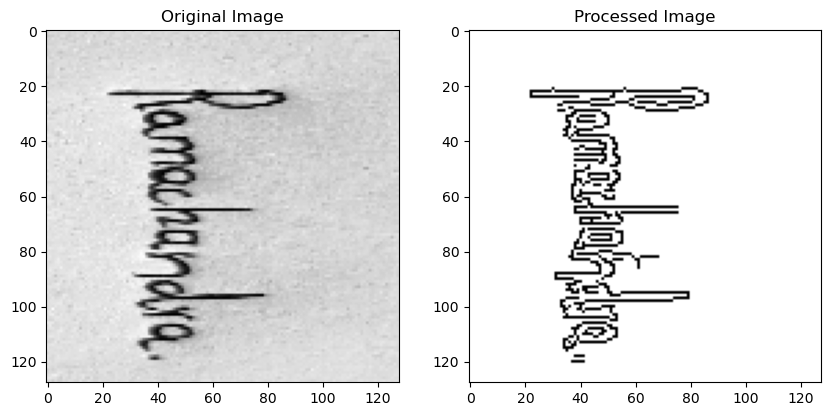

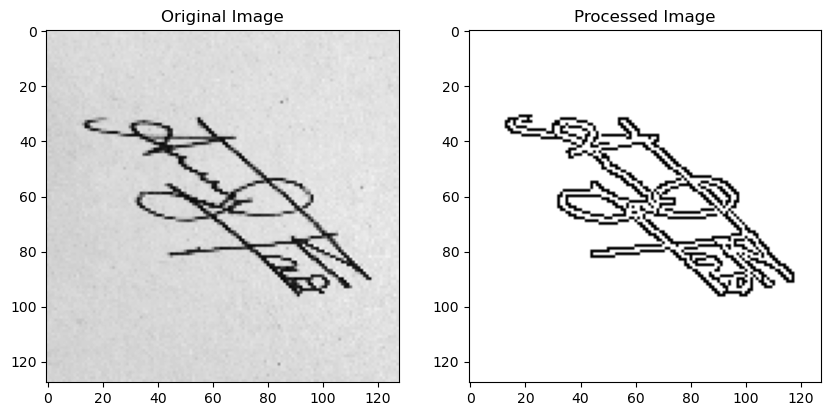

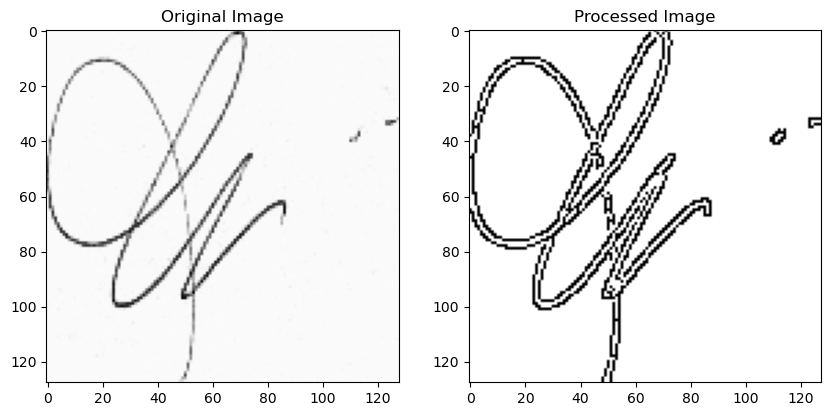

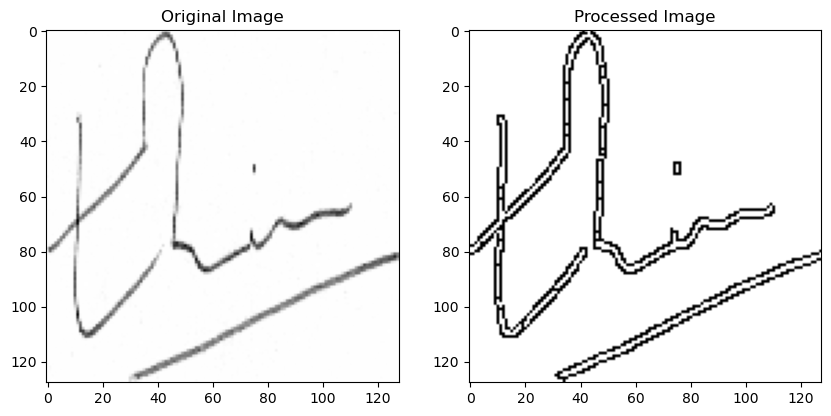

In [7]:

# Display a single image before and after preprocessing
def display_image_before_after(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (128, 128))
    processed_img = preprocess_image(file_path)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img_resized, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Processed Image')
    plt.imshow(processed_img, cmap='gray')
    plt.show()

# Example image display
example_image_path = 'WhatsApp Image 2024-07-10 at 10.49.40 PM.jpeg'  # Provide a valid image path here
display_image_before_after(example_image_path)
# Example image display
example_image_path = 'img1.jpeg'  # Provide a valid image path here
display_image_before_after(example_image_path)
# Example image display
example_image_path = 'sign_data/test/049/08_049.png'  # Provide a valid image path here
display_image_before_after(example_image_path)# Example image display
example_image_path = 'sign_data/train/001_forg/0201001_01.png'  # Provide a valid image path here
display_image_before_after(example_image_path)

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import DepthwiseConv2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Add, Input, Activation, Reshape, multiply, GlobalMaxPooling2D
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import LearningRateScheduler

def squeeze_excite_block(input, ratio=16):
    init = input
    channel_axis = -1
    filters = init.shape[channel_axis]

    se = GlobalAveragePooling2D()(init)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x

def depthwise_separable_conv_block(x, filters, kernel_size=(3, 3), stride=1):
    x = DepthwiseConv2D(kernel_size, padding='same', strides=stride, activation='relu')(x)
    x = Conv2D(filters, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = squeeze_excite_block(x)
    return x

def build_smaller_model(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)
    
    # Initial convolutional block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Depthwise separable convolution blocks
    x = depthwise_separable_conv_block(x, 64)
    x = MaxPooling2D((2, 2))(x)
    
    x = depthwise_separable_conv_block(x, 128)
    x = MaxPooling2D((2, 2))(x)
    
    x = depthwise_separable_conv_block(x, 256)
    x = MaxPooling2D((2, 2))(x)
    
    x = depthwise_separable_conv_block(x, 512)
    x = MaxPooling2D((2, 2))(x)

    x = depthwise_separable_conv_block(x, 1024)
    x = MaxPooling2D((2, 2))(x)

    # Global Average Pooling and final dense layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    optimizer = AdamW(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

model = build_smaller_model()
# Callbacks
callbacks = [
    LearningRateScheduler(lr_schedule),
]

# Summary of the model
model.summary()

2024-07-10 22:53:22.878510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 22:53:22.898005: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 22:53:22.898166: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 64, 64,    │        320 │ max_pooling2d[0]… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      2,112 │ depthwise_conv2d… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 4)   │        256 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 64)  │        256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ multiply[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 32, 32,    │        640 │ max_pooling2d_1[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      8,320 │ depthwise_conv2d… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 128) │          0 │ global_average_p

 Total params: 894,273 (3.41 MB)

 Trainable params: 890,241 (3.40 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [9]:
# Train the model
history = model.fit(X_train, y_train, batch_size=18, epochs=50, validation_data=(X_test, y_test), callbacks=callbacks)
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

Epoch 1/50


I0000 00:00:1720632206.834743  630640 service.cc:145] XLA service 0x7ff17c002280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720632206.834782  630640 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-07-10 22:53:26.938678: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-10 22:53:27.402109: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1720632208.848124  630861 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 240 bytes spill stores, 240 bytes spill loads



13/77 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4778 - loss: 0.6933

I0000 00:00:1720632215.344817  630640 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


73/77 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5150 - loss: 0.6926

I0000 00:00:1720632217.826392  631439 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 344 bytes spill stores, 344 bytes spill loads



77/77 ━━━━━━━━━━━━━━━━━━━━ 24s 157ms/step - accuracy: 0.5164 - loss: 0.6925 - val_accuracy: 0.4935 - val_loss: 0.6935 - learning_rate: 1.0000e-04
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5800 - loss: 0.6808 - val_accuracy: 0.4935 - val_loss: 0.6945 - learning_rate: 1.0000e-04
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6655 - loss: 0.6212 - val_accuracy: 0.4935 - val_loss: 0.6982 - learning_rate: 1.0000e-04
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7148 - loss: 0.5826 - val_accuracy: 0.4935 - val_loss: 0.7101 - learning_rate: 1.0000e-04
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7319 - loss: 0.5298 - val_accuracy: 0.4935 - val_loss: 0.7348 - learning_rate: 1.0000e-04
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7604 - loss: 0.4976 - val_accuracy: 0.4935 - val_loss: 0.8229 - learning_rate: 1.0000e-04
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7910 - loss: 0

I0000 00:00:1720632284.424570  639728 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1720632284.937391  639718 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 192 bytes spill stores, 192 bytes spill loads



1/5 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.9375 - loss: 0.1283

I0000 00:00:1720632289.214273  640005 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 240 bytes spill stores, 240 bytes spill loads



In [ ]:
# Save the model
model.save('enhanced_signature_verification_model3_2.keras')

In [ ]:
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
models=[]
models.append(load_model("enhanced_signature_verification_model3_1.keras"))
models.append(load_model("enhanced_signature_verification_model3_2.keras"))

In [ ]:
def preprocess_image1(image_path):
    processed_img = preprocess_image(image_path)
    processed_img = processed_img / 255.0
    processed_img = processed_img.reshape(1, 128, 128, 1)
    return processed_img

def predict_signature(model, real_signature_path, test_signature_path):
    real_img = preprocess_image1(real_signature_path)
    test_img = preprocess_image1(test_signature_path)
    
    real_pred = model.predict(real_img)
    test_pred = model.predict(test_img)
    
    difference = np.abs(real_pred - test_pred)
    return difference*100

In [ ]:
# Example usage
real_signature_path = 'img1.jpeg'  # Provide a valid image path
test_signature_path = 'img2.jpeg'  # Provide a valid image path

In [ ]:
for i,model in enumerate(models):
    difference = predict_signature(model, real_signature_path, test_signature_path)
    print(f"Difference: {difference} by model{i+1}\n\n")

In [ ]:
# Example usage
real_signature_path = 'img1.jpeg'  # Provide a valid image path
test_signature_path = 'img3.jpeg'  # Provide a valid image path

In [ ]:
for i,model in enumerate(models):
    difference = predict_signature(model, real_signature_path, test_signature_path)
    print(f"Difference: {difference} by model{i+1}\n\n")

In [ ]:
# Example usage
real_signature_path = 'img1.jpeg'   # Provide a valid image path
test_signature_path = 'img4.jpeg'  # Provide a valid image path

In [ ]:
for i,model in enumerate(models):
    difference = predict_signature(model, real_signature_path, test_signature_path)
    print(f"Difference: {difference} by model{i+1}\n\n")

In [ ]:
# Example usage
real_signature_path = 'WhatsApp Image 2024-07-10 at 10.49.40 PM.jpeg'   # Provide a valid image path
test_signature_path = 'img1.jpeg'  # Provide a valid image path

In [ ]:
for i,model in enumerate(models):
    difference = predict_signature(model, real_signature_path, test_signature_path)
    print(f"Difference: {difference} by model{i+1}\n\n")